In [1]:
# Run only once to avoid changing working directory. If required restart kernel and run again
import os
os.chdir(os.path.dirname(os.getcwd()))
repo_dir = os.getcwd()
print(repo_dir)

/home/shobuj/project_ws/src/drone


In [2]:
train_with_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/train/with_mask/'
train_without_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/train/without_mask'
test_with_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/test/with_mask'
test_without_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/test/without_mask'
print(len(os.listdir(train_with_mask)))
print(len(os.listdir(train_without_mask)))
print(len(os.listdir(test_with_mask)))
print(len(os.listdir(test_without_mask)))

341
275
66
132


0
(320, 433)
1
(320, 428)
2
(187, 203)
3
(190, 318)
4
(379, 465)
5
(320, 428)


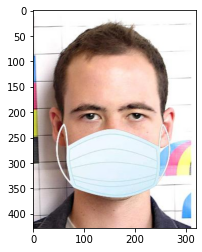

In [3]:
import sys
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt

main_dir = train_with_mask
files = listdir(main_dir)
# you can change file extension below to read other image types
images_list = [i for i in files if i.endswith('.jpg')] ## output file names only
i = 0
for idx,image in enumerate(images_list):
  if i>5:
    break
  i = i + 1
  print(idx)
  img = Image.open(main_dir + image)
  print(img.size)
  plt.imshow(img)
  #img = img.resize((480, 600))

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Input,AveragePooling2D
#from keras.applications import InceptionV3
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelBinarizer
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

2021-08-14 17:14:06.557881: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
train_DIR = repo_dir + '/assets/Dataset/maskdata/maskdata/train'
test_DIR = repo_dir + '/assets/Dataset/maskdata/maskdata/test'

Image_gen = ImageDataGenerator(rescale=1.0/255.0,
                               horizontal_flip = True,
                               rotation_range = 50,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               zoom_range = 0.2,
                               fill_mode = 'nearest',
                               validation_split = 0.2)

train_generator = Image_gen.flow_from_directory(train_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "training")

val_generator = Image_gen.flow_from_directory(train_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "validation")

test_generator = Image_gen.flow_from_directory(test_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                )

Found 493 images belonging to 2 classes.
Found 123 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [7]:
input = keras.layers.Input(shape=(224,224,3))
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3), input_tensor= input)

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

2021-08-14 17:14:08.263348: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-14 17:14:08.299327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 17:14:08.299659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce MX250 computeCapability: 6.1
coreClock: 1.582GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 44.76GiB/s
2021-08-14 17:14:08.299694: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-08-14 17:14:08.302208: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-08-14 17:14:08.304476: I tensorflow/stream_executor/platform

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(train_generator, batch_size=BS, validation_data=val_generator, epochs=EPOCHS,verbose = 2)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20


2021-08-14 17:14:13.422826: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-08-14 17:14:13.666731: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


25/25 - 9s - loss: 0.5736 - accuracy: 0.7099 - val_loss: 0.2269 - val_accuracy: 0.9593
Epoch 2/20
25/25 - 8s - loss: 0.2195 - accuracy: 0.9189 - val_loss: 0.1259 - val_accuracy: 0.9756
Epoch 3/20
25/25 - 8s - loss: 0.1593 - accuracy: 0.9412 - val_loss: 0.0942 - val_accuracy: 0.9756
Epoch 4/20
25/25 - 6s - loss: 0.1268 - accuracy: 0.9574 - val_loss: 0.0906 - val_accuracy: 0.9675
Epoch 5/20
25/25 - 8s - loss: 0.0866 - accuracy: 0.9696 - val_loss: 0.0578 - val_accuracy: 0.9919
Epoch 6/20
25/25 - 7s - loss: 0.0662 - accuracy: 0.9878 - val_loss: 0.0663 - val_accuracy: 0.9756
Epoch 7/20
25/25 - 10s - loss: 0.0510 - accuracy: 0.9858 - val_loss: 0.0619 - val_accuracy: 0.9756
Epoch 8/20
25/25 - 10s - loss: 0.0490 - accuracy: 0.9919 - val_loss: 0.0541 - val_accuracy: 0.9756
Epoch 9/20
25/25 - 9s - loss: 0.0451 - accuracy: 0.9878 - val_loss: 0.0478 - val_accuracy: 0.9675
Epoch 10/20
25/25 - 9s - loss: 0.0507 - accuracy: 0.9817 - val_loss: 0.0473 - val_accuracy: 0.9837
Epoch 11/20
25/25 - 9s - los

In [10]:
model.evaluate(test_generator,batch_size= BS, verbose=2)

10/10 - 4s - loss: 0.0500 - accuracy: 0.9848


[0.05000831186771393, 0.9848484992980957]

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(test_generator, batch_size=BS,verbose=2, )

predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...
10/10 - 3s


In [12]:
test_labels=test_generator.classes 
print(classification_report(test_labels, predIdxs))

              precision    recall  f1-score   support

           0       0.32      0.32      0.32        66
           1       0.66      0.67      0.66       132

    accuracy                           0.55       198
   macro avg       0.49      0.49      0.49       198
weighted avg       0.55      0.55      0.55       198



In [13]:
#model.save("drone_vision/saved_model", save_format="h5")

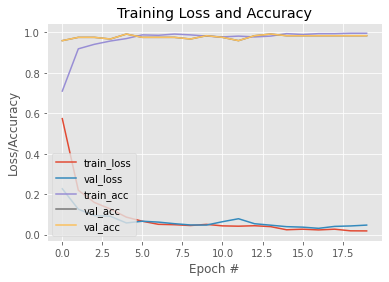

In [14]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [15]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [16]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="yourInputName"))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="drone_vision/frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

2021-08-14 17:17:19.523546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 17:17:19.524374: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-08-14 17:17:19.524534: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-08-14 17:17:19.525914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 17:17:19.526441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce MX250 computeCapability: 6.1
coreClock: 1.582GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 44.76GiB/s
2021-08-14 17:17:19.526528

--------------------------------------------------
Frozen model layers: 
yourInputName
functional_1/Conv1_pad/Pad/paddings
functional_1/Conv1_pad/Pad
functional_1/Conv1/Conv2D/ReadVariableOp/resource
functional_1/Conv1/Conv2D/ReadVariableOp
functional_1/Conv1/Conv2D
functional_1/bn_Conv1/ReadVariableOp/resource
functional_1/bn_Conv1/ReadVariableOp
functional_1/bn_Conv1/ReadVariableOp_1/resource
functional_1/bn_Conv1/ReadVariableOp_1
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp/resource
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1/resource
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1
functional_1/bn_Conv1/FusedBatchNormV3
functional_1/Conv1_relu/Relu6
functional_1/expanded_conv_depthwise/depthwise/ReadVariableOp/resource
functional_1/expanded_conv_depthwise/depthwise/ReadVariableOp
functional_1/expanded_conv_depthwise/depthwise
functional_1/expanded_conv_depthwise_BN/ReadVariableOp/resource
functional_1

'drone_vision/frozen_models/frozen_graph.pb'

In [17]:
pb_file = 'drone_vision/frozen_models/frozen_models/frozen_graph.pb'
graph_def = tf.compat.v1.GraphDef()

try:
    with tf.io.gfile.GFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())
except:
    with tf.gfile.FastGFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())

# Delete weights
for i in reversed(range(len(graph_def.node))):
    if graph_def.node[i].op == 'Const':
        del graph_def.node[i]

graph_def.library.Clear()

tf.compat.v1.train.write_graph(graph_def, repo_dir + "/drone_vision/frozen_models/frozen_models", 'model.pbtxt', as_text=True)

'/home/shobuj/project_ws/src/drone/drone_vision/frozen_models/frozen_models/model.pbtxt'

In [18]:
# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow('drone_vision/frozen_models/frozen_models/frozen_graph.pb')
# Input image
img = cv2.imread('assets/test_photos/frands.jpg')
rows, cols, channels = img.shape

# Use the given image as input, which needs to be blob(s).
tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(224, 224), swapRB=True, crop=False))

# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()

# Loop on the outputs
for detection in networkOutput[0,0]:

    score = float(detection[2])
    if score > 0.9:

        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows

        #draw a red rectangle around detected objects
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)

# Show the image with a rectagle surrounding the detected objects 
cv2.imshow('Image', img)
cv2.waitKey()
cv2.destroyAllWindows()

TypeError: 'numpy.float32' object is not iterable